# Maize Crop Analysis

## Importing libraries

In [1]:
# imports

# data manipulation
import pandas as pd
import numpy as np 

# visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# modeling

import os
import cv2


import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


## Load the data

In [2]:

# Set the base directory of your dataset
base_dir = "/Users/jeniphermawia/Desktop/crop"

data = []
for folder in os.listdir(base_dir):
    if folder.startswith("Maize"):
        label = folder.replace("Maize___", "")
        folder_path = os.path.join(base_dir, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                image_path = os.path.join(folder_path, file)
                data.append([image_path, label])

# Create a dataframe
df = pd.DataFrame(data, columns=["image_path", "label"])

# Save to CSV
df.to_csv("maize_dataset.csv", index=False)

print("CSV with maize image paths and labels saved as 'maize_dataset.csv'")


CSV with maize image paths and labels saved as 'maize_dataset.csv'


## Data Exploration

In [3]:
# top of the data
df.head()

,image_path,label
0,/Users/jeniphermawia/Desktop/crop/Maize leaf b...,Maize leaf beetle
1,/Users/jeniphermawia/Desktop/crop/Maize leaf b...,Maize leaf beetle
2,/Users/jeniphermawia/Desktop/crop/Maize leaf b...,Maize leaf beetle
3,/Users/jeniphermawia/Desktop/crop/Maize leaf b...,Maize leaf beetle
4,/Users/jeniphermawia/Desktop/crop/Maize leaf b...,Maize leaf beetle


In [4]:
# check bottom of the data
df.tail()

,image_path,label
5353,/Users/jeniphermawia/Desktop/crop/Maize leaf s...,Maize leaf spot
5354,/Users/jeniphermawia/Desktop/crop/Maize leaf s...,Maize leaf spot
5355,/Users/jeniphermawia/Desktop/crop/Maize leaf s...,Maize leaf spot
5356,/Users/jeniphermawia/Desktop/crop/Maize leaf s...,Maize leaf spot
5357,/Users/jeniphermawia/Desktop/crop/Maize leaf s...,Maize leaf spot


In [5]:
# number of rows and columns
df.shape

(5358, 2)

There are 5358 rows and 2 columns

In [6]:
# datatypes
df.dtypes

image_path    object
label         object
dtype: object

## Data Cleaning

In [7]:
# check for missing values
print("Number of missing values in each row:")
print(df.isnull().sum())

Number of missing values in each row:
image_path    0
label         0
dtype: int64


In [8]:
# check for duplicates
print("Number of duplicated rows:", df.duplicated().sum())

Number of duplicated rows: 0


## Data Analysis/visualization

In [9]:
# Clean and check paths
df['image_path'] = df['image_path'].str.strip()
valid_rows = df[df['image_path'].apply(os.path.exists)]

print(f"Found {len(valid_rows)} valid image paths out of {len(df)} total.")


Found 5358 valid image paths out of 5358 total.


In [10]:
# remove spaces on the file paths
df['image_path'] = df['image_path'].str.strip()

# Group and sample the data
sampled_df = df.groupby('label').apply(lambda x: x.sample(min(5, len(x)))).reset_index(drop=True)

# Load up to 25 valid RGB images
sample_rgb_images = []
sample_labels = []
count = 0

for _, row in sampled_df.iterrows():
    path = row['image_path']
    label = row['label']

    try:
        img = Image.open(path).convert('RGB')  # Full color
        img = img.resize((100, 100))  # Resize for display only
        sample_rgb_images.append(img)
        sample_labels.append(label)
        count += 1
    except Exception as e:
        print(f"⚠️ Skipped: {path} → {e}")
    
    if count == 25:
        break

/var/folders/w1/2dgk1bpd4ng81qnmdfxxmhqh0000gp/T/ipykernel_7892/3283189153.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label').apply(lambda x: x.sample(min(5, len(x)))).reset_index(drop=True)


/Users/jeniphermawia/Desktop/crop/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


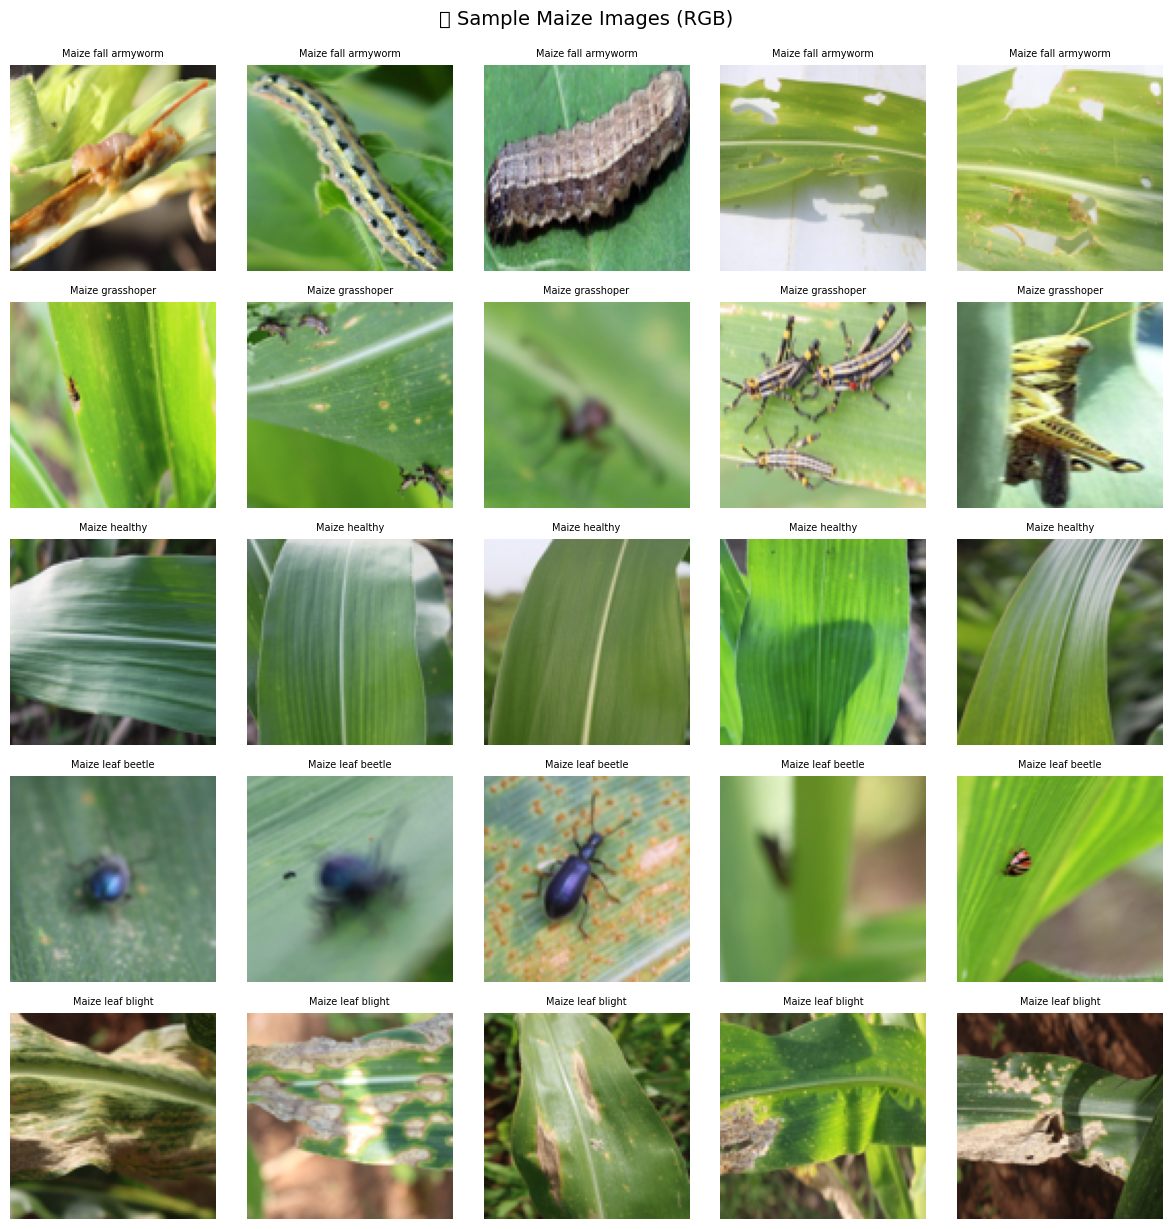

In [11]:
# plot the 25 images 
plt.figure(figsize=(12, 12))
for i in range(len(sample_rgb_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_rgb_images[i])
    plt.title(sample_labels[i], fontsize=7)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("🌾 Sample Maize Images (RGB)", y=1.02, fontsize=14)
plt.show()


/var/folders/w1/2dgk1bpd4ng81qnmdfxxmhqh0000gp/T/ipykernel_7892/1795973830.py:6: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jeniphermawia/Desktop/crop/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


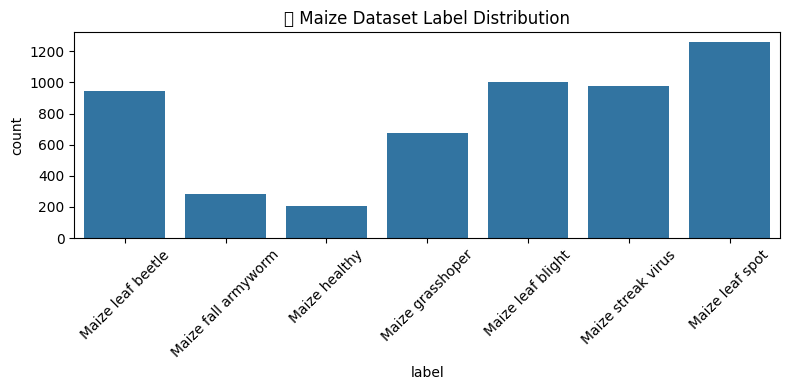

In [12]:
# visualize the data
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=df)
plt.title("🌾 Maize Dataset Label Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Modeling

In [13]:
df['label'].shape

(5358,)

In [14]:
# get the data in colored format
gray_images = []
y_labels = []
for _, row in df.iterrows():
    path = row['image_path']
    label = row['label']
    try:
        img = Image.open(path).convert('L')  # GRAYSCALE images
        img = img.resize((28, 28))
        gray_images.append(np.array(img))
        y_labels.append(label)
    except:
        continue

# Convert to numpy arrays
X = np.array(gray_images).reshape(-1, 28, 28, 1) / 255.0  # Normalize



### Split the data into train and test points

In [15]:
X.shape

(5289, 28, 28, 1)

In [16]:


# Encode class labels to integers
le = LabelEncoder()
y_integer = le.fit_transform(y_labels)
y_categorical = to_categorical(y_integer)

# Optional: print class mapping
print("Label Mapping:")
for i, label in enumerate(le.classes_):
    print(f"{i} = {label}")


Label Mapping:
0 = Maize fall armyworm
1 = Maize grasshoper
2 = Maize healthy
3 = Maize leaf beetle
4 = Maize leaf blight
5 = Maize leaf spot
6 = Maize streak virus


## Split to train and test sets

In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

## CNN Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')  # One node per class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/jeniphermawia/Desktop/crop/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,647 (877.53 KB)

 Trainable params: 224,647 (877.53 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2075 - loss: 1.8684 - val_accuracy: 0.3828 - val_loss: 1.7666
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3188 - loss: 1.6919 - val_accuracy: 0.3960 - val_loss: 1.4777
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3913 - loss: 1.5124 - val_accuracy: 0.4348 - val_loss: 1.3979
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4240 - loss: 1.4366 - val_accuracy: 0.4698 - val_loss: 1.3304
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4297 - loss: 1.3633 - val_accuracy: 0.4716 - val_loss: 1.3016
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4645 - loss: 1.3115 - val_accuracy: 0.4896 - val_loss: 1.2612
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4592 - loss: 1.2989 - val_accuracy: 0.4839 - val_loss: 1.2377
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5062 - loss: 1.2411 - val_accu

## Model Performance

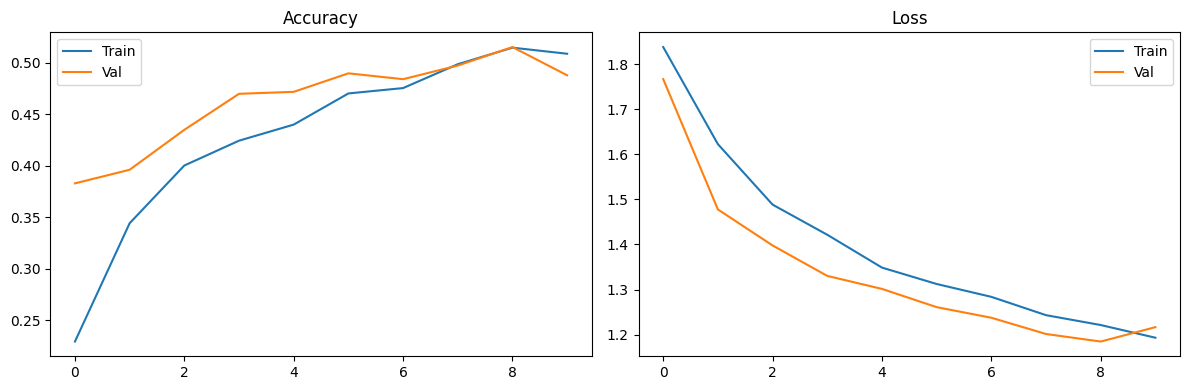

In [20]:

# Accuracy and loss plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                     precision    recall  f1-score   support

Maize fall armyworm       1.00      0.09      0.16        57
   Maize grasshoper       0.53      0.44      0.48       134
      Maize healthy       0.31      0.27      0.29        41
  Maize leaf beetle       0.63      0.86      0.73       187
  Maize leaf blight       0.51      0.38      0.43       198
    Maize leaf spot       0.41      0.46      0.43       248
 Maize streak virus       0.41      0.47      0.44       193

           accuracy                           0.49      1058
          macro avg       0.54      0.42      0.42      1058
       weighted avg       0.51      0.49      0.47      1058



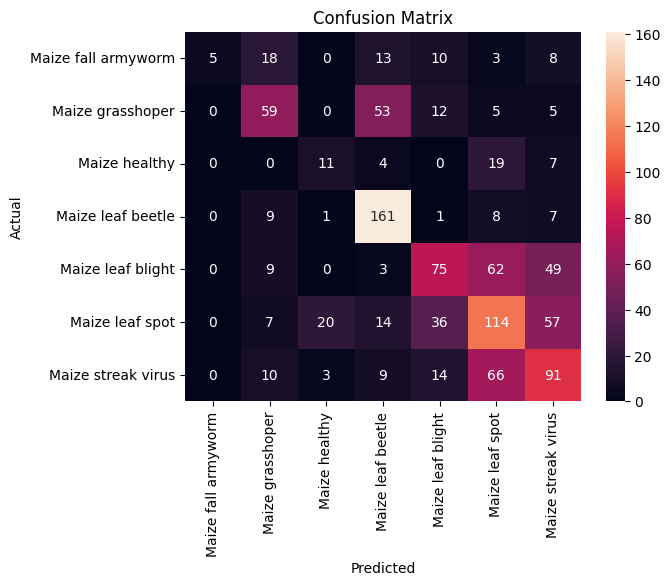

In [21]:
# prediction

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Improve the model

In [25]:
# use colored images instead of gray

# get the data in colored format
colored_images = []
y_colored_labels = []
for _, row in df.iterrows():
    path = row['image_path']
    label = row['label']
    try:
        img = Image.open(path).convert('RGB')  # COLORED images
        img = img.resize((28, 28))
        colored_images.append(np.array(img))
        y_colored_labels.append(label)
    except:
        continue

# Convert to numpy arrays
X_colored = np.array(colored_images).reshape(-1, 28, 28, 1) / 255.0  # Normalize

# Encode class labels to integers
le = LabelEncoder()
y_colored_integer = le.fit_transform(y_labels)
y_colored_categorical = to_categorical(y_colored_integer)

# Optional: print class mapping
print("Label Mapping:")
for i, label in enumerate(le.classes_):
    print(f"{i} = {label}")

Label Mapping:
0 = Maize fall armyworm
1 = Maize grasshoper
2 = Maize healthy
3 = Maize leaf beetle
4 = Maize leaf blight
5 = Maize leaf spot
6 = Maize streak virus


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_colored, y_colored_categorical, test_size=0.2, random_state=42, stratify=y_colored_categorical)

ValueError: Found input variables with inconsistent numbers of samples: [15867, 5289]

In [ ]:

model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/Users/jeniphermawia/Desktop/crop/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# history2 = model.fit(datagen.flow(X_train, y_train, batch_size=32),
#                     validation_data=(X_test, y_test),
#                     epochs=20)

history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


In [ ]:
y_pred2 = model2.predict(X_test)
y_pred_labels2 = np.argmax(y_pred2, axis=1)
y_true_labels2 = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels2, y_pred_label2, target_names=le.classes_))